In [12]:
from datasets.SegmentedPETCTDataset import SegmentedPETCTDataset
from model.BrownianBridge.LatentBrownianBridgeModel import LatentBrownianBridgeModel
import segmentation_models_pytorch as smp
import yaml
import argparse
import omegaconf 
import matplotlib.pyplot as plt
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch.utils.data import DataLoader
from pprint import pprint

CHECKPOINT_PATH = '/home/PET-CT/thaind/ckpts'
DATA_PATH = '/home/PET-CT/splited_data_15k'
IMAGE_SIZE = 256
CT_MAX = 2047
PET_MAX = 32767
BATCH_SIZE = 16

In [13]:
# class SegmentationModel(pl.LightningModule):

#     def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
#         super().__init__()
#         self.model = smp.create_model(
#             arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
#         )

#         # preprocessing parameteres for image
#         params = smp.encoders.get_preprocessing_params(encoder_name)
#         self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
#         self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

#         # for image segmentation dice loss could be the best first choice
#         self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

#     def forward(self, image):
#         # normalize image here
#         image = (image - self.mean) / self.std
#         mask = self.model(image)
#         return mask

#     def shared_step(self, batch, stage):
        
#         image = batch[0]

#         # Shape of the image should be (batch_size, num_channels, height, width)
#         # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
#         assert image.ndim == 4

#         # Check that image dimensions are divisible by 32, 
#         # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
#         # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
#         # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
#         # and we will get an error trying to concat these features
#         h, w = image.shape[2:]
#         assert h % 32 == 0 and w % 32 == 0

#         mask = batch[1]

#         # Shape of the mask should be [batch_size, num_classes, height, width]
#         # for binary segmentation num_classes = 1
#         assert mask.ndim == 4

#         # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
#         assert mask.max() <= 1.0 and mask.min() >= 0

#         logits_mask = self.forward(image)
        
#         # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
#         loss = self.loss_fn(logits_mask, mask)

#         # Lets compute metrics for some threshold
#         # first convert mask values to probabilities, then 
#         # apply thresholding
#         prob_mask = logits_mask.sigmoid()
#         pred_mask = (prob_mask > 0.5).float()

#         # We will compute IoU metric by two ways
#         #   1. dataset-wise
#         #   2. image-wise
#         # but for now we just compute true positive, false positive, false negative and
#         # true negative 'pixels' for each image and class
#         # these values will be aggregated in the end of an epoch
#         tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

#         return {
#             "loss": loss,
#             "tp": tp,
#             "fp": fp,
#             "fn": fn,
#             "tn": tn,
#         }

#     def shared_epoch_end(self, outputs, stage):
#         # aggregate step metics
#         tp = torch.cat([x["tp"] for x in outputs])
#         fp = torch.cat([x["fp"] for x in outputs])
#         fn = torch.cat([x["fn"] for x in outputs])
#         tn = torch.cat([x["tn"] for x in outputs])

#         # per image IoU means that we first calculate IoU score for each image 
#         # and then compute mean over these scores
#         per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
#         # dataset IoU means that we aggregate intersection and union over whole dataset
#         # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
#         # in this particular case will not be much, however for dataset 
#         # with "empty" images (images without target class) a large gap could be observed. 
#         # Empty images influence a lot on per_image_iou and much less on dataset_iou.
#         dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

#         metrics = {
#             f"{stage}_per_image_iou": per_image_iou,
#             f"{stage}_dataset_iou": dataset_iou,
#         }
        
#         self.log_dict(metrics, prog_bar=True)

#     def training_step(self, batch, batch_idx):
#         return self.shared_step(batch, "train")            

#     def training_epoch_end(self, outputs):
#         return self.shared_epoch_end(outputs, "train")

#     def validation_step(self, batch, batch_idx):
#         return self.shared_step(batch, "valid")

#     def validation_epoch_end(self, outputs):
#         return self.shared_epoch_end(outputs, "valid")

#     def test_step(self, batch, batch_idx):
#         return self.shared_step(batch, "test")  

#     def test_epoch_end(self, outputs):
#         return self.shared_epoch_end(outputs, "test")

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=0.0001)

In [14]:
class SegmentationModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        # self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
        # self.loss_fn = torch.nn.CrossEntropyLoss()
        
    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        # assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        # assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask.long())

        # You can use argmax to get the predicted class for each pixel
        pred_mask = torch.argmax(logits_mask, dim=1)

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        # tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="multiclass", num_classes=3)
        
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [15]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict) or isinstance(value, omegaconf.dictconfig.DictConfig):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

In [16]:
def get_image_paths_from_dir(fdir):
    flist = os.listdir(fdir)
    flist.sort()
    image_paths = []
    for i in range(0, len(flist)):
        fpath = os.path.join(fdir, flist[i])
        if os.path.isdir(fpath):
            image_paths.extend(get_image_paths_from_dir(fpath))
        else:
            image_paths.append(fpath)
    return image_paths

In [17]:
def get_dataset_by_stage(data_path, stage, enc_dec, image_size, ct_max_pixel, pet_max_pixel, flip):
    ct_paths = get_image_paths_from_dir(os.path.join(data_path, f'{stage}/A'))
    pet_paths = get_image_paths_from_dir(os.path.join(data_path, f'{stage}/B'))

    return SegmentedPETCTDataset(ct_paths, pet_paths, enc_dec, image_size, ct_max_pixel, pet_max_pixel, flip)

In [18]:
f = open('/home/PET-CT/thaind/BBDM_folk/configs/conditional_LBBDM.yaml', 'r')
dict_config = yaml.load(f, Loader=yaml.FullLoader)

nconfig = dict2namespace(dict_config)
ltbbdm = LatentBrownianBridgeModel(nconfig.model)

train_dataset = get_dataset_by_stage(DATA_PATH, 'train', ltbbdm, (IMAGE_SIZE, IMAGE_SIZE), CT_MAX, PET_MAX, True)
val_dataset = get_dataset_by_stage(DATA_PATH, 'val', ltbbdm, (IMAGE_SIZE, IMAGE_SIZE), CT_MAX, PET_MAX, False)
test_dataset = get_dataset_by_stage(DATA_PATH, 'test', ltbbdm, (IMAGE_SIZE, IMAGE_SIZE), CT_MAX, PET_MAX, False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Restored from /home/PET-CT/vqgan/vq1_3_69.ckpt
load vqgan from /home/PET-CT/vqgan/vq1_3_69.ckpt


(-0.5, 63.5, 63.5, -0.5)

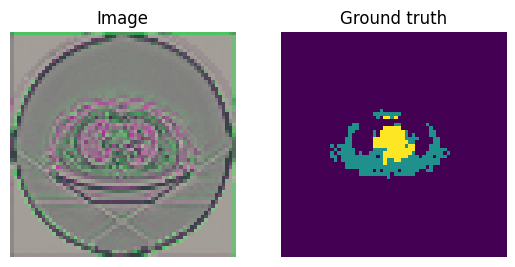

In [19]:
img, lab, name = train_dataset[2347]

plt.subplot(1, 2, 1)
plt.imshow(img.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lab.numpy().squeeze()) # just squeeze classes dim, because we have only one class
plt.title("Ground truth")
plt.axis("off")

In [20]:
CHECKPOINT_FILE_PATH = CHECKPOINT_PATH + "/Unet/lightning_logs/version_4/checkpoints/epoch=0-step=1500.ckpt"
model_name = "Unet"
encoder_name = "resnet34"
model = SegmentationModel.load_from_checkpoint(CHECKPOINT_FILE_PATH, arch=model_name, encoder_name=encoder_name, in_channels=3, out_classes=3)

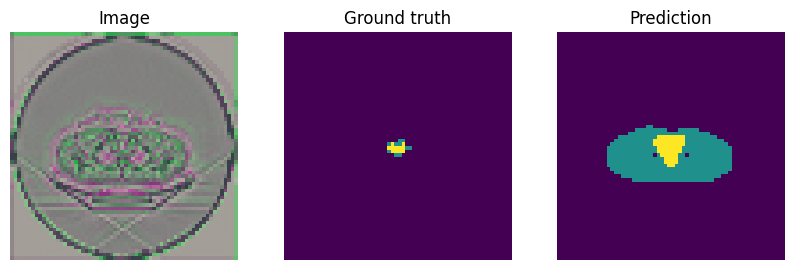

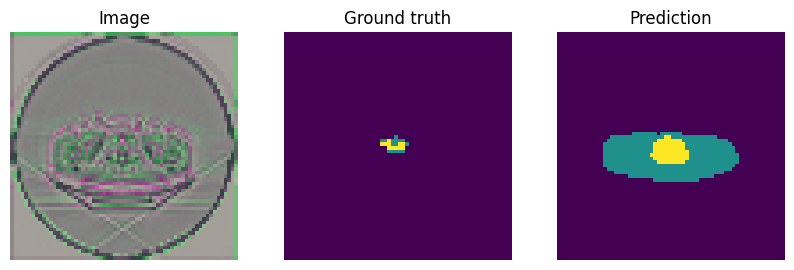

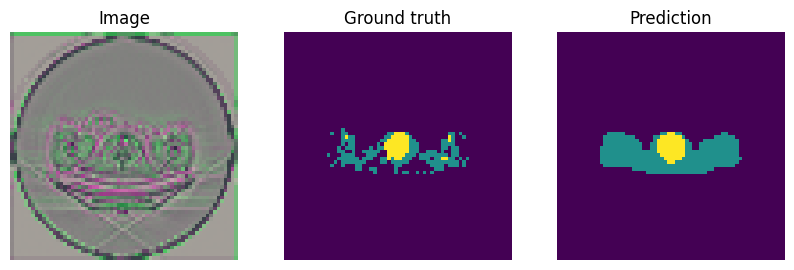

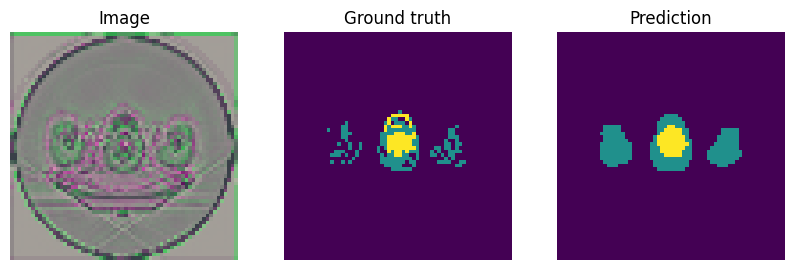

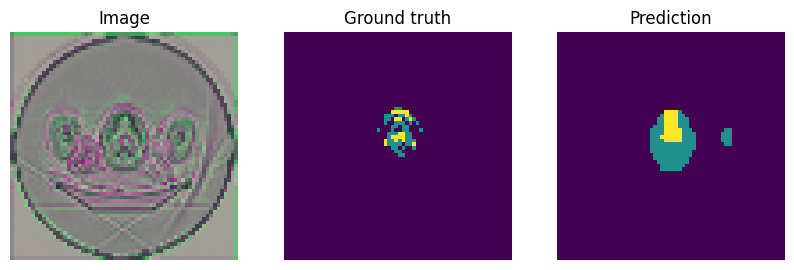

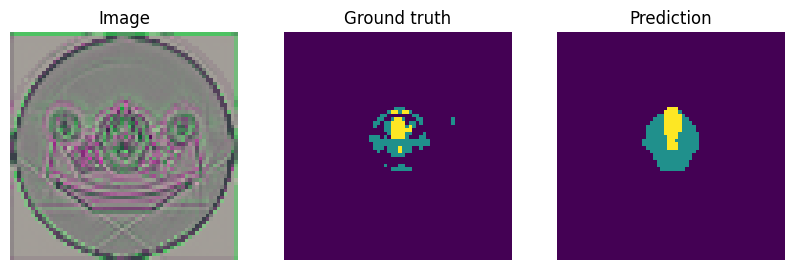

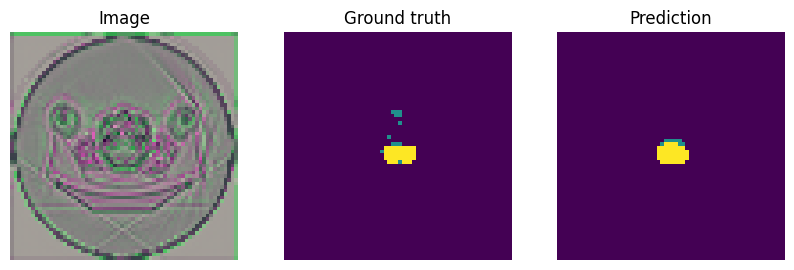

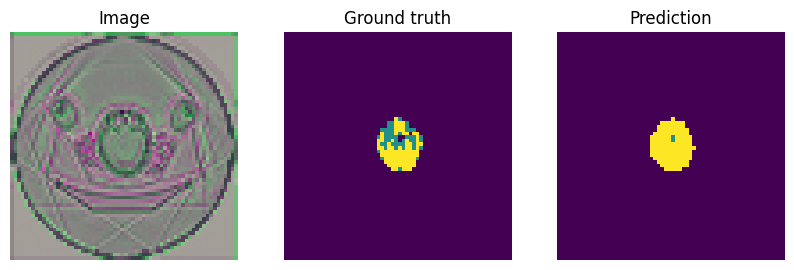

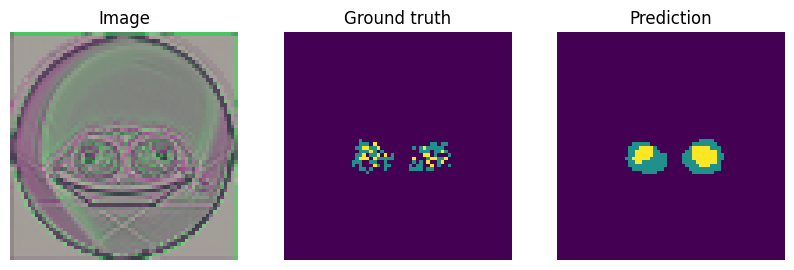

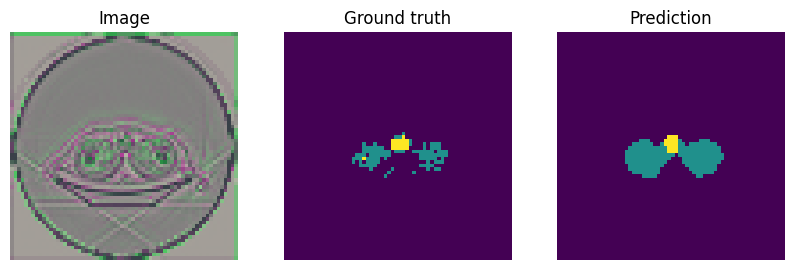

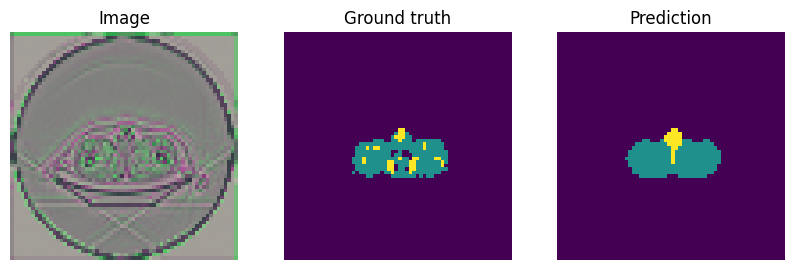

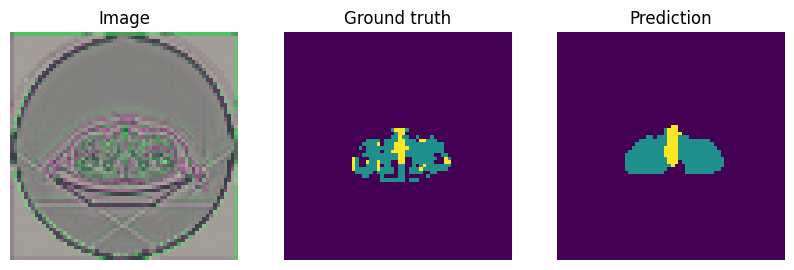

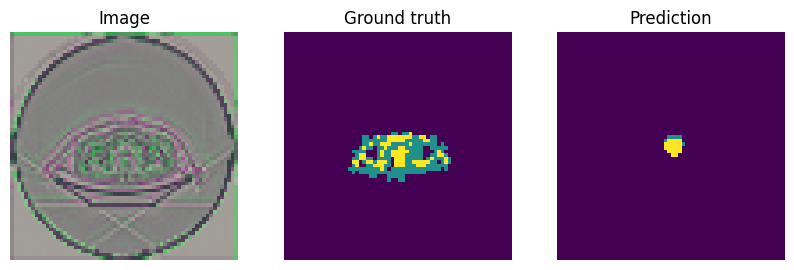

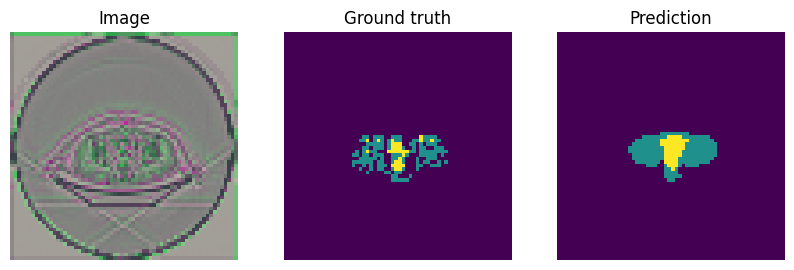

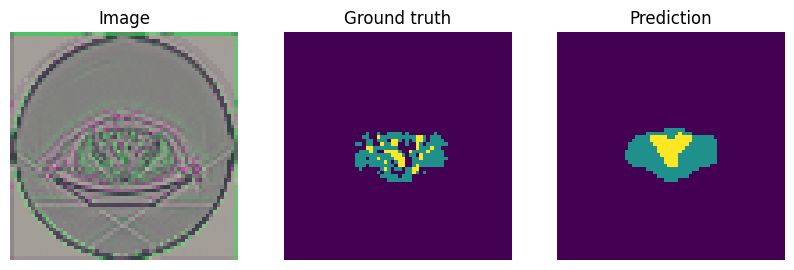

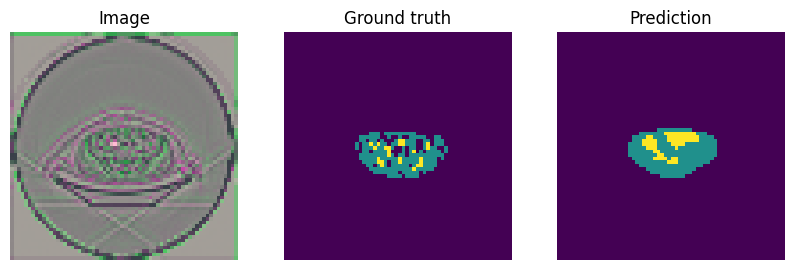

In [21]:
INDEX = 0
batch = list(test_dataloader)[INDEX]
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
    
# pr_masks = logits.sigmoid()
pr_masks = torch.argmax(logits, dim=1)

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

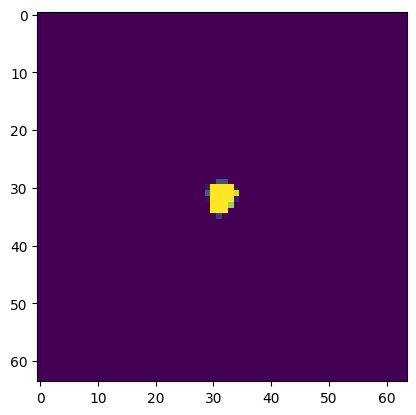

In [22]:
import numpy as np
pred = np.load("/home/PET-CT/thaind/ckpts/Unet_resnet34/lightning_logs/version_0/samples/train/4.npy")

plt.imshow(pred)